In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
yaba_properties = pd.read_json("./data/yaba-properties.json")
surulere_properties = pd.read_json("./data/surulere-properties.json")
maryland_properties = pd.read_json("./data/maryland-properties.json")
gbagada_properties = pd.read_json("./data/gbagada-properties.json")

data = pd.concat([yaba_properties, surulere_properties, maryland_properties, gbagada_properties])

## Data cleaning

In [3]:
# Get number of rooms
def roomCount(type):
    if (len(re.findall('\d+', type)) > 0):
        return re.findall('\d+', type)[0]
    elif (re.search(r'(self|flat)', type, flags=re.IGNORECASE)):
        return "1"

data['number of rooms'] = data.type.map(roomCount).astype('int64')

In [4]:
# Get city and town
def cityAndTown(location):
    arr = location.split(', ')
    arr.pop()
    arr.reverse()
    
    city = arr[0].strip()
    town = arr[1].strip() if len(arr) > 1 else np.nan
    
    return city, town

data['city'] = data.location.map(lambda loc: cityAndTown(loc)[0])
data['town'] = data.location.map(lambda loc: cityAndTown(loc)[1])

In [5]:
# convert rent to int
data['rent'] = data['rent'].map(lambda r: r.replace(',','')).astype('int64')

In [6]:
data['id'] = range(0, len(data))
data = data.set_index("id")

In [7]:
from datetime import datetime, timedelta

# extract month added
def extractDate(item):
    date = item.replace('Added ', '').replace('on ', '').lower()
    if date == "yesterday":
        return (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
    else:
        return date

data['addedOn'] = data.addedOn.map(lambda x: pd.to_datetime(extractDate(x)))
data['monthAdded'] = data.addedOn.map(lambda x: x.month_name())

In [8]:
# extract serviced or furnished
data['serviced'] = data.shortDesc.map(lambda desc: int(bool(re.search(r'serviced', desc, flags=re.IGNORECASE))))
data['furnished'] = data.shortDesc.map(lambda desc: int(bool(re.search(r'furnished', desc, flags=re.IGNORECASE))))

In [9]:
# extract number of bathrooms and number of toilets
data.metaProps.head()

def extractKey(prop, key):
    if prop.get(key):
        return prop.get(key)
    elif prop.get(key + "s"):
        return prop.get(key + "s")
    else:
        return 0

data["number of bathrooms"] = data.metaProps.map(lambda prop: extractKey(prop, "Bathroom"))
data["number of toilets"] = data.metaProps.map(lambda prop: extractKey(prop, "Toilet"))

In [10]:
# extract house agent
def extractAgent(x): 
    agent = x.replace('\n', '').replace('\xa0', '').strip(' ')
    if len(agent) == 0:
        return np.nan
    else:
        return agent

data["marketedBy"] = data.marketedBy.map(extractAgent)

In [11]:
# remove all investment based houses
data.at[412, 'rent'] = 325000

data[data['shortDesc'] == "Sunplanet Smart Landlord Investment"]
data.drop(index=192, inplace=True)

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/mini-flats/lagos/yaba/onike/549971-newly-built-2bedroom-at-onike"]
data.drop(index=322, inplace=True)

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/lagos/surulere/779480-luxury-and-executive-3-bedrooms-with-3-tiolets-with-wardrobes"]
data.at[416, 'rent'] = 1000000

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/self-contained/lagos/gbagada/782003-a-executive-brand-newly-built-ensuite-2-bedrooms-flat"]
data.at[713, 'number of rooms'] = "2"

data[data["link"] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/lagos/gbagada/gbagada-phase-1/706117-newly-built-2-bedroom"]
data.at[781, 'number of rooms'] = "2"

data[data["link"] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/self-contained/lagos/yaba/onike/798173-newly-built-roomself-for-15-years-lease"]
data.drop(index=9, inplace=True)

data[data['rent'] == 40000000]
data.drop(index=814, inplace=True)

In [12]:
data['number of bathrooms'] = pd.to_numeric(data['number of bathrooms'])
data['number of toilets'] = pd.to_numeric(data['number of toilets'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 813
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   type                 811 non-null    object        
 1   shortDesc            811 non-null    object        
 2   link                 811 non-null    object        
 3   rent                 811 non-null    int64         
 4   addedOn              811 non-null    datetime64[ns]
 5   location             811 non-null    object        
 6   marketedBy           767 non-null    object        
 7   metaProps            811 non-null    object        
 8   number of rooms      811 non-null    int64         
 9   city                 811 non-null    object        
 10  town                 676 non-null    object        
 11  monthAdded           811 non-null    object        
 12  serviced             811 non-null    int64         
 13  furnished            811 non-null  

## EDA

In [13]:
data.groupby(['number of rooms', 'city']).rent.agg([len, min, max])

len      min      max
number of rooms city                           
1               Gbagada    25   200000   700000
                Maryland   13    84000  1000000
                Surulere   96   150000  1000000
                Yaba      156   120000  1600000
2               Gbagada    50   700000  2500000
                Maryland   22   600000  2500000
                Surulere   65   500000  2200000
                Yaba       85   400000  2000000
3               Gbagada    80   800000  3000000
                Maryland   26   800000  4000000
                Surulere   77   600000  3000000
                Yaba       95   500000  2700000
4               Gbagada     8  1200000  3000000
                Surulere    6   750000  3200000
                Yaba        5  1300000  3000000
5               Maryland    1  3000000  3000000
                Yaba        1  3500000  3500000

## Apply advance data cleaning

In [14]:
df_o = data[['rent', 'number of rooms', 'city', 'serviced', 'furnished', 
           'number of bathrooms', 'number of toilets', 'monthAdded']]

In [15]:
df = pd.get_dummies(df_o, columns=['city'], prefix='city')
df = pd.get_dummies(df, columns=['monthAdded'], prefix='monthAdded')

In [16]:
df.head()

,rent,number of rooms,serviced,furnished,number of bathrooms,number of toilets,city_Gbagada,city_Maryland,city_Surulere,city_Yaba,monthAdded_April,monthAdded_August,monthAdded_December,monthAdded_February,monthAdded_January,monthAdded_July,monthAdded_June,monthAdded_March,monthAdded_May,monthAdded_November,monthAdded_October,monthAdded_September
id,,,,,,,,,,,,,,,,,,,,,,
0,400000,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,400000,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,800000,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,500000,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1300000,2,1,0,2,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


## Apply model

In [17]:
df.describe()

,rent,number of rooms,serviced,furnished,number of bathrooms,number of toilets,city_Gbagada,city_Maryland,city_Surulere,city_Yaba,monthAdded_April,monthAdded_August,monthAdded_December,monthAdded_February,monthAdded_January,monthAdded_July,monthAdded_June,monthAdded_March,monthAdded_May,monthAdded_November,monthAdded_October,monthAdded_September
count,8.110000e+02,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.00000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,1.088612e+06,2.039457,0.051788,0.018496,1.940814,2.302096,0.200986,0.076449,0.300863,0.421702,0.003699,0.087546,0.10111,0.008631,0.013564,0.064118,0.020962,0.019729,0.012330,0.401973,0.162762,0.103576
std,6.687547e+05,0.903175,0.221735,0.134818,1.027498,1.235777,0.400985,0.265879,0.458916,0.494136,0.060745,0.282808,0.30166,0.092560,0.115741,0.245115,0.143345,0.139152,0.110424,0.490599,0.369376,0.304898
min,8.400000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.500000e+05,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000e+06,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.500000e+06,3.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,4.000000e+06,5.000000,1.000000,1.000000,5.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


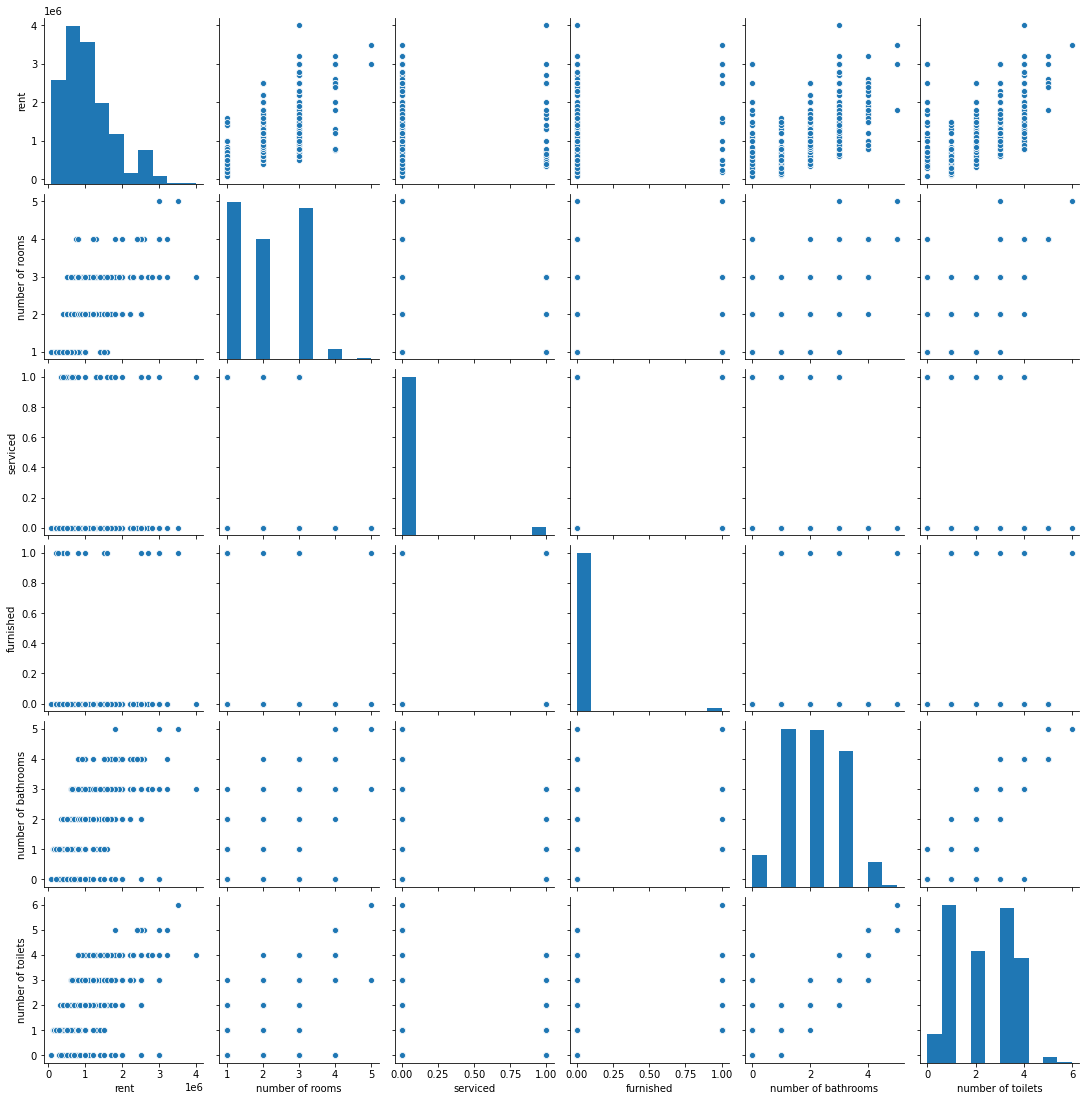

In [18]:
sns.pairplot(df_o)

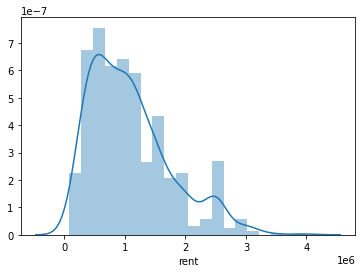

In [19]:
sns.distplot(df['rent'])

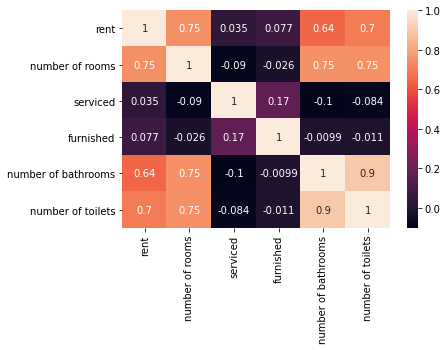

In [21]:
sns.heatmap(df_o.corr(), annot=True)

In [24]:
X = df.drop(columns=['rent'])
y = df.rent

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [31]:
from sklearn import metrics

def applyModel(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # print metrics evaluation
    print("MAE", metrics.mean_absolute_error(y_test, predictions))
    print("MSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    
    return predictions

#### Linear regression

In [32]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

lm_preds = applyModel(lm)

MAE 290700.1421657298
MSE 379755.4214242452


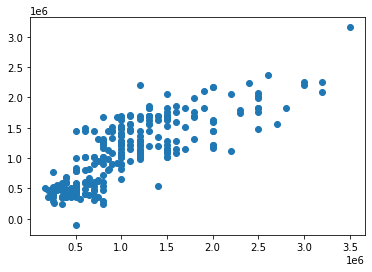

In [34]:
# Plot errors    
plt.scatter(y_test, lm_preds)

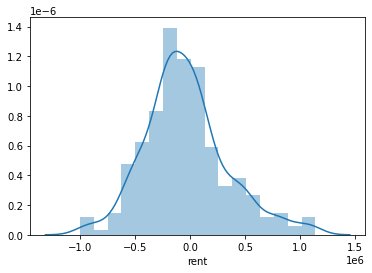

In [35]:
sns.distplot((y_test - lm_preds))

#### Decision trees

In [39]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)
dt_preds = applyModel(dt)

MAE 296896.0616534475
MSE 410025.0625855438


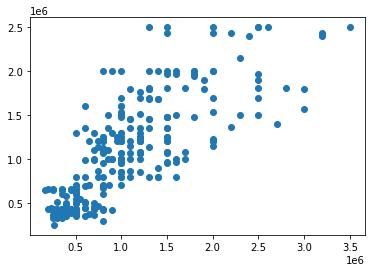

In [40]:
plt.scatter(y_test, dt_preds)

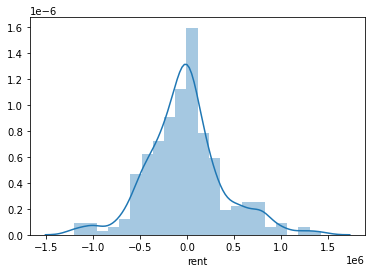

In [41]:
sns.distplot((y_test - dt_preds))

#### Random forest

In [42]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_leaf_nodes=50, random_state=0)
rf_preds = applyModel(rf)

MAE 275193.99441806023
MSE 374868.4444749246


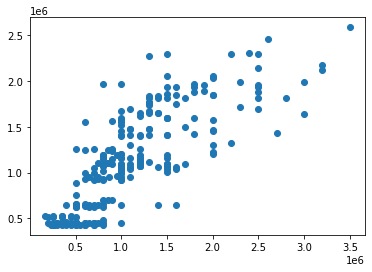

In [43]:
plt.scatter(y_test, rf_preds)

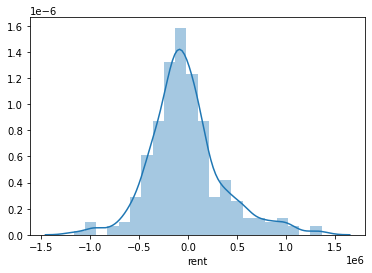

In [44]:
sns.distplot((y_test - rf_preds))

## Final thoughts

Using random forest gives us the minimum errors compared to LinearRegression and DecisionTrees

MAE: NGN 275,194

MSE: NGN 374,868